In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mpld3
import statsmodels.api as sm
import itertools
from fbprophet import Prophet

In [30]:
filename = "CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv"
df = pd.read_csv(filename)

In [31]:
# check for missing data, if any
df['rides'].isnull().values.sum()

0

In [32]:
# change date to datetime format
df['datetime'] = pd.to_datetime(df['date'], format='%m/%d/%Y')

In [33]:
# df['rides'] = df.groupby(['stationname','datetime'])['rides'].mean().reset_index()['rides']

In [34]:
# extract season, day of week, month, year
seasons = ['Winter','Winter','Spring','Spring','Spring','Summer',
           'Summer','Summer','Fall','Fall','Fall','Winter']
months = range(1,13)
mtos = dict(zip(months,seasons))
df['season'] = df['datetime'].dt.month.map(mtos)
df['weekday']=df['datetime'].dt.dayofweek.map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday',
                                              4:'Friday', 5:'Saturday', 6:'Sunday'})
df['month']=pd.DatetimeIndex(df['datetime']).month
df['year']=pd.DatetimeIndex(df['datetime']).year

In [35]:
daytypes = df.daytype.unique().tolist()
daytypedict = dict(zip(daytypes, ['Sun/Hol', 'Weekday', 'Sat']))
df['daytype']=df['daytype'].map(daytypedict)

In [45]:
morse_df = df[df['stationname']=='Morse']
all_dates = pd.date_range(start=morse_df['datetime'].min(), end=morse_df['datetime'].max(), freq='d')
all_dates                                                                

DatetimeIndex(['2001-01-01', '2001-01-02', '2001-01-03', '2001-01-04',
               '2001-01-05', '2001-01-06', '2001-01-07', '2001-01-08',
               '2001-01-09', '2001-01-10',
               ...
               '2018-06-21', '2018-06-22', '2018-06-23', '2018-06-24',
               '2018-06-25', '2018-06-26', '2018-06-27', '2018-06-28',
               '2018-06-29', '2018-06-30'],
              dtype='datetime64[ns]', length=6390, freq='D')

In [46]:
morse_df = pd.DataFrame(morse_df.groupby('datetime')['rides'].mean())
morse_df.shape

(6390, 1)

In [47]:
morse_df.resample('D').asfreq().shape

(6390, 1)

In [48]:
morse_df[morse_df.index.duplicated(keep=False)]

,rides
datetime,


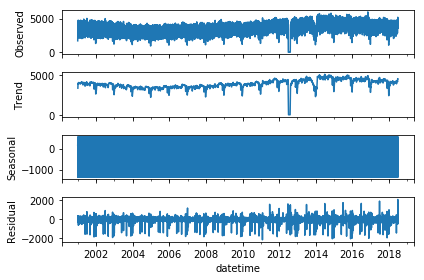

In [49]:
decomposition = sm.tsa.seasonal_decompose(morse_df, model='additive')
fig = decomposition.plot()
plt.show()

In [56]:
morse_prophet = morse_df.reset_index().rename(columns={'datetime':'ds', 'rides':'y'})

In [57]:
m = Prophet()
m.fit(morse_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AttributeError: 'StanModel' object has no attribute 'fit_class'

In [16]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
pdq
# seasonal_pdq = [tuple(list(x) + [12]) for x in pdq]
# seasonal_pdq = seasonal_pdq[0:2]
# seasonal_pdq
# print('Examples of parameter combinations for Seasonal ARIMA...')
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [17]:
y = morse_df

mod = sm.tsa.statespace.SARIMAX(y,
#                                 order=param,
#                                 seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [27]:
dir(results)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  rides   No. Observations:                 6390
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -52393.156
Date:                Sun, 23 Dec 2018   AIC                         104790.312
Time:                        16:04:51   BIC                         104803.837
Sample:                    01-01-2001   HQIC                        104794.994
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9749      0.003    289.247      0.000       0.968       0.981
sigma2       7.77e+05   1.24e+04     62.455      0.000    7.53e+05    8.01e+05
===================================================================================
Ljung-Box (Q):                    31153.80   Jarque-Bera (JB):               227.69
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.43
Prob(H) (two-sided):                  0.78   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
y = morse_df
arima_list=[]
for param in pdq:
#     print(param)
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            arima_list.append([param, param_seasonal, results.aic])
        except:
            continue
arima_df = pd.Dataframe(arima_list)            

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/stats

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-pac

In [ ]:
# plot ridership over time
def make_time_plot(df, station):    
    d = df[df['stationname']==station]
    x = 'datetime'
    y = 'rides'
    a=d[x]
    b=d[y]
    fig, ax = plt.subplots()
    ax.plot(a, b)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.title(station)

In [ ]:
def make_layered_hist(array, station, variablename, variablelist):
    fig, ax = plt.subplots()
    for var in variablelist:
        condarray = array[(array['stationname']==station) & (array[variablename]==var)]
        dist=sns.distplot(condarray['rides'], ax=ax, label=var)
        ax.legend()
        ax.set_xlabel('# of Rides Daily', fontsize=16)
    dist=dist.get_figure()
    ax.set_ylabel('Frequency', fontsize=16)
    ax.set_xlim([0,25000])
    plt.title('Distribution of ' + station +' Rides', fontsize=20)
    return fig, ax
#     kde.savefig('figs/react_kde' + condDay + '.png')
#     plt.clf()